In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end

find_singular (generic function with 1 method)

In [5]:
qon_c(E)=find_singular(E, (E, p) -> E-mDc-mDsc - p^2 / (2 * μf(mDc, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDn-mDsn - p^2 / (2 * μf(mDn, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
qon_0(3.87165)|>println
qon_c(3.87165)|>println

0.002632213869851304 + 0.004723182681375603im
0.0008087602747414445 + 0.12618606917576505im


In [7]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [8]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [9]:
function getqw(E,Λ;ω=0.1,V0=-0.1,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E),qon_c(E)
    for i in eachindex(xxx)
        qi[2+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [10]:
getqw(mDn+mDsn-40e-6,0.6)

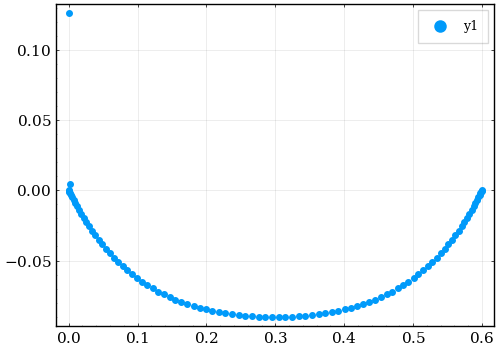

In [11]:
scatter(real.(qi[1:end]),imag.(qi[1:end]))

In [10]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [11]:
function VMat!(E;Λ=0.5,C=1,a = 0.0,a1=0.0,isπ=true,plist=qi,des=Vmat)
    getqw(E,Λ)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xn(E,plist[l], plist[m],k1,k1;C=C,a = a,a1=a1,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m],k2,k1;C=C,a = a,a1=a1,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m],k1,k2; C=C,a = a,a1=a1,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xc(E,plist[l], plist[m],k2,k2;C=C,a = a,a1=a1,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

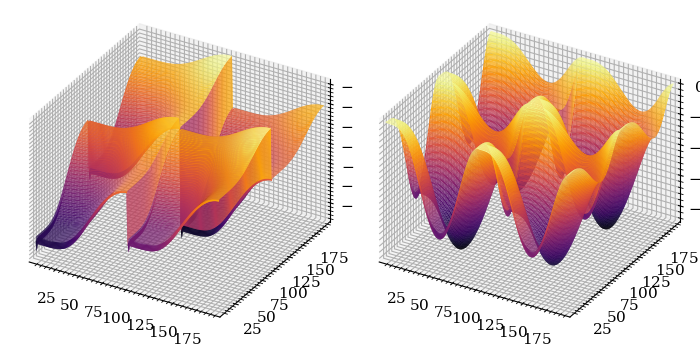

In [12]:
VMat!(3.87165,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

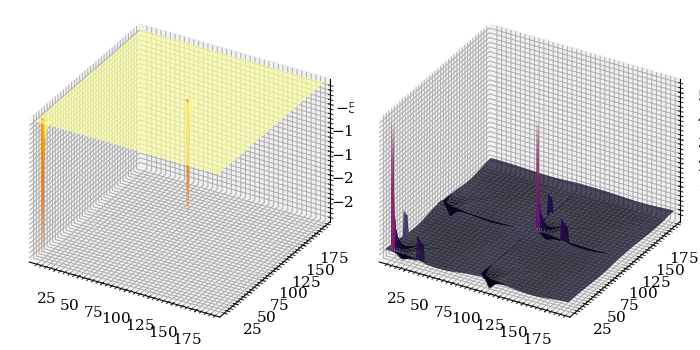

In [13]:
VMat!(3.87165,isπ=true)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [14]:
Gc(E,q)=1/(2π^2)/(E-mDc-mDsc-q^2/(2*μf(mDc,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDn-mDsn-q^2/(2*μf(mDn,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [15]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    k1,k2=qi[1],qi[2]
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [16]:
function detVG(E;Λ=0.5,a = 0.0,a1=0.0,C=1,isπ=true)
    VMat!(E;Λ=Λ,a=a,a1=a1,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [17]:
function TMat!(E;Λ=0.5,a = 0.0,a1=0.0,C=1,des=Tmat,isπ=true)
    VMat!(E;Λ=Λ,a=a,a1=a1,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [18]:
@btime TMat!(3.87165)

  31.172 ms (2768 allocations: 2.61 MiB)


# Extract pole position

## C=+

In [19]:
function find_poles(pars;C=1)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ;C=C, Λ = _lam,a1=_a1,isπ=true)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsn - 40e-6, 0])
    println((tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2])
    tmp
end

find_poles (generic function with 1 method)

In [20]:
find_poles([0.73,1.0])

-1.8582372524278412e-5 - 1.2424001337676201e-5im


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8716500000000003, 0.0]
 * Zero: [3.871671417627476, -1.2424001337676201e-5]
 * Inf-norm of residuals: 0.684035
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 988
 * Jacobian Calls (df/dx): 945

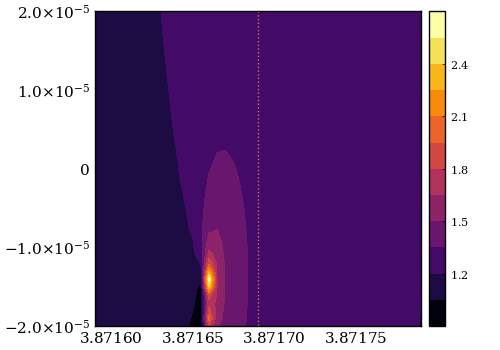

In [22]:
let Ev=collect(mDn+mDsn-100e-6:5e-6:mDn+mDsn+100e-6),Γv=collect(-20e-6:1e-6:20e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.73,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsn],ls=:dot,label=false)
end

## C=-

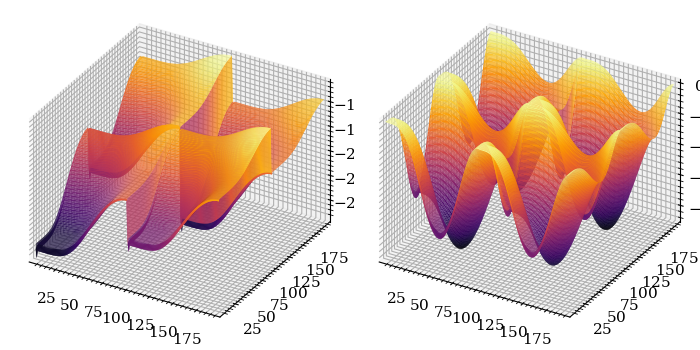

In [26]:
VMat!(3.87165;C=-1,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [23]:
find_poles([0.73,1.0];C=-1)

-0.02754923701458223 - 0.0009980022050850882im


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8716500000000003, 0.0]
 * Zero: [3.844140762985418, -0.0009980022050850882]
 * Inf-norm of residuals: 0.000000
 * Iterations: 16
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 14
 * Jacobian Calls (df/dx): 12

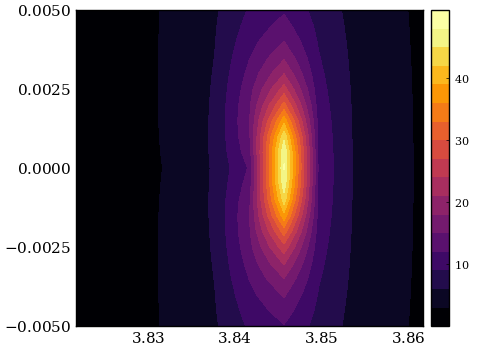

In [25]:
let Ev=collect(mDn+mDsn-50e-3:4e-3:mDn+mDsn-10e-3),Γv=collect(-5e-3:5e-4:5e-3)
    resv=[1/abs(detVG(e+im*γ;C=-1,Λ=0.73,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end